# Learning TV Ads Video Classification to Product Identification

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import zipfile as zf
import seaborn as sns

from numpy import expand_dims
from matplotlib import pyplot
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Shopping Brasil videos dataset preprocessing

Upon splitting video files into ~10k 1 sec image frames, we have organized them into 4 folders (classes), making sure classes are equally distributed among Dev and Test sets. Thus, we applied ImageDataGenerator (from Keras preprocessing library) to label all frames at scale with very few lines of code.

Unzip compressed directories to preprocessing. Commented because it was executed only once.

In [2]:
#! unzip ~/frames.zip -d ~/CS230_Final Project/data

### Labeling process at scale with ImageDataGenerator

In [2]:
train_datagen = ImageDataGenerator(
        rescale=1./255, zoom_range=0.5, rotation_range=40, horizontal_flip=True)
dev_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train_generator = train_datagen.flow_from_directory('data/frames/train', target_size=(192, 240), color_mode='rgb', 
                                                    shuffle = True, batch_size=32, class_mode='categorical')

Found 7211 images belonging to 4 classes.


In [4]:
dev_generator = dev_datagen.flow_from_directory('data/frames/dev', target_size=(192, 240), color_mode='rgb', 
                                                shuffle = True, batch_size=32, class_mode='categorical')

Found 1689 images belonging to 4 classes.


In [5]:
test_generator = test_datagen.flow_from_directory('data/frames/test', target_size=(192, 240), color_mode='rgb', 
                                                  shuffle = True, batch_size=32, class_mode='categorical')

Found 1509 images belonging to 4 classes.


In [6]:
class_ids = train_generator.class_indices
print(class_ids)

{'beers': 0, 'notphone_beer': 1, 'otherphones': 2, 'samsung': 3}


Text(0.5, 0, 'beers: "0", notphone_beer: "1", otherphones: "2", samsung: "3"')

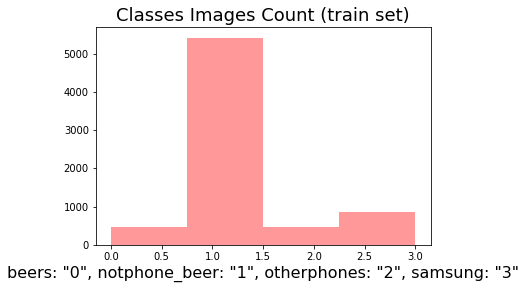

In [7]:
train_dist = train_generator.classes
sns.distplot(train_dist, kde=False, color='red', bins = 4)
plt.title('Classes Images Count (train set)', fontsize=18)
plt.xlabel('beers: "0", notphone_beer: "1", otherphones: "2", samsung: "3"', fontsize=16)

In [17]:
# Class imbalance mitigation
class_weights = {0:16, 1:1.3, 2:15, 3:8}

float32
(192, 240, 3)


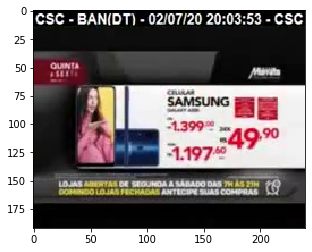

In [8]:
# Related libraries
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data = image.imread('data/frames/train/samsung/12502338_00007.png')
# Data type and dimensions
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
pyplot.imshow(data)
pyplot.show()

## Baseline model: training a small ConvNet applying Keras high level framework

In [9]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.metrics import categorical_accuracy, categorical_crossentropy

### Shallow CNN architecture (inspired by Tensorflow Image Classification Tutorial) 
https://www.tensorflow.org/tutorials/images/classification

In [10]:
POOL_SIZE = (2, 2)
KERNEL_SIZE = (3, 3)
INPUT_SHAPE = (192, 240, 3)

In [12]:
def shallow_NN():
# Initialise a model
    model = Sequential()

# First conv layer
    model.add(Conv2D(32, KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', use_bias=True, strides=1))

# Second conv layer
    model.add(Conv2D(64, KERNEL_SIZE, activation='relu', strides=1, use_bias=True))

# First pool layer
    model.add(MaxPooling2D(pool_size=POOL_SIZE, strides=2))
    
# Third conv layer
    model.add(Conv2D(128, KERNEL_SIZE, activation='relu', strides=1, use_bias=True))

# Sencond pool layer
    model.add(MaxPooling2D(pool_size=POOL_SIZE, strides=2))

# Flattening
    model.add(Flatten())

# FC layers
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=4, activation='softmax'))
    
    return model

In [13]:
shallow_model = shallow_NN()

In [11]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [15]:
shallow_model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [16]:
batch_size = 64
epochs = 350

In [17]:
shallow_model.fit_generator(train_generator, steps_per_epoch=1024 // batch_size, epochs=epochs,
                            validation_data=dev_generator, validation_steps=512 // batch_size,
                            class_weight=class_weights)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/350
16/16 [==============================] - 25s 562ms/step - loss: 7.0770 - accuracy: 0.2147 - val_loss: 1.3928 - val_accuracy: 0.0977
Epoch 2/350
16/16 [==============================] - 8s 509ms/step - loss: 6.6146 - accuracy: 0.1668 - val_loss: 1.4532 - val_accuracy: 0.1719
Epoch 3/350
16/16 [==============================] - 9s 535ms/step - loss: 4.9626 - accuracy: 0.2959 - val_loss: 1.3073 - val_accuracy: 0.5742
Epoch 4/350
16/16 [==============================] - 9s 583ms/step - loss: 5.1542 - accuracy: 0.4006 - val_loss: 1.4055 - val_accuracy: 0.1602
Epoch 5/350
16/16 [==============================] - 8s 495ms/step - loss: 5.1603 - accuracy: 0.1733 - val_loss: 1.3414 - val_accuracy: 0.4453
Epoch 6/350
16/16 [==============================] - 9s 524ms/step - loss: 5.2499 - accuracy: 0.3758 - val_loss: 1.3045 - val_accuracy: 0.4727
Epoch 7/350
16/16 [==============================] - 9s 548ms/step - loss: 4.8165 - accuracy: 0.4090 - val_loss: 1.3668 - val_accuracy: 0.332

### Initial Analysis to define net steps

In [18]:
shallow_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 238, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 188, 236, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 94, 118, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 116, 128)      73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 58, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 341504)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

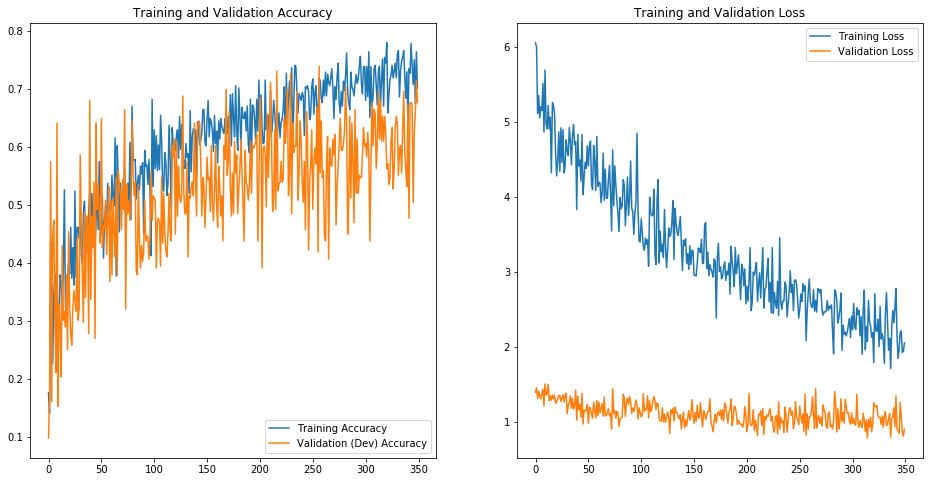

In [19]:
acc = shallow_model.history.history['accuracy']
val_acc = shallow_model.history.history['val_accuracy']

loss = shallow_model.history.history['loss']
val_loss = shallow_model.history.history['val_loss']

epoch_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, acc, label='Training Accuracy')
plt.plot(epoch_range, val_acc, label='Validation (Dev) Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label='Training Loss')
plt.plot(epoch_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Checking test set performance metric to evaluate against val_accuracy

In [30]:
shallow_model.save_weights('deep_NN_b64_e350.h5')

In [29]:
shallow_model.load_weights('deep_NN_b64_e350.h5')

In [26]:
scores = shallow_model.evaluate(test_generator)
print("Accuracy = ", scores[1])

48/48 [==============================] - 5s 94ms/step - loss: 0.7393 - accuracy: 0.7197
Accuracy =  0.7196819186210632


In [21]:
steps = 53
S_pred = shallow_model.predict_generator(dev_generator, steps=steps)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Text(0.5, 15.0, 'Predicted label')

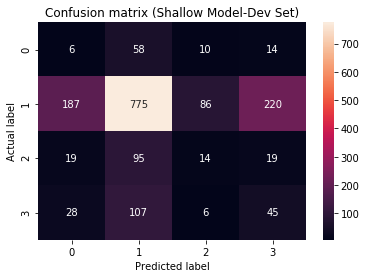

In [23]:
test_preds = np.argmax(S_pred, axis=-1)
test_trues = dev_generator.classes
cm = confusion_matrix(test_trues, test_preds)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix (Shallow Model-Dev Set)')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [24]:
# Precision, Recall and F1-Score
beer_precision = (cm[0][0])/(cm[0][0]+cm[1][0]+cm[2][0]+cm[3][0])
beer_recall = (cm[0][0])/(cm[0][0]+cm[0][1]+cm[0][2]+cm[0][3])
beer_f1_score = (2*beer_precision*beer_recall)/(beer_precision+beer_recall)
                                           
not_phonebeer_precision = (cm[1][1])/(cm[1][1]+cm[1][0]+cm[1][2]+cm[1][3])
not_phonebeer_recall = (cm[1][1])/(cm[1][1]+cm[0][1]+cm[2][1]+cm[3][1])
not_phonebeer_f1_score = (2*not_phonebeer_precision*not_phonebeer_recall)/(not_phonebeer_precision+not_phonebeer_recall)

otherphones_precision = (cm[2][2])/(cm[2][2]+cm[2][0]+cm[2][1]+cm[2][3])
otherphones_recall = (cm[2][2])/(cm[2][2]+cm[0][2]+cm[1][2]+cm[3][2])
otherphones_f1_score = (2*otherphones_precision*otherphones_recall)/(otherphones_precision+otherphones_recall)

samsung_precision = (cm[3][3])/(cm[3][3]+cm[3][0]+cm[3][1]+cm[3][2])
samsung_recall = (cm[3][3])/(cm[3][3]+cm[0][3]+cm[1][3]+cm[2][3])
samsung_f1_score = (2*samsung_precision*samsung_recall)/(samsung_precision+samsung_recall)

print("Beer Precision = ", beer_precision)
print("Beer Recall = ", beer_recall)
print("Beer F1-Score = ", beer_f1_score)

print("Negative Precision = ", not_phonebeer_precision)
print("Negative Recall = ", not_phonebeer_recall)
print("Negative F1-Score = ", not_phonebeer_f1_score)

print("Other Phones Precision = ", otherphones_precision)
print("Other Phones Recall = ", otherphones_recall)
print("Other Phones F1-Score = ", otherphones_f1_score)

print("Samsung Precision = ", samsung_precision)
print("Samsung Phones Recall = ", samsung_recall)
print("Samsung Phones F1-Score = ", samsung_f1_score)

Beer Precision =  0.025
Beer Recall =  0.06818181818181818
Beer F1-Score =  0.03658536585365854
Negative Precision =  0.611198738170347
Negative Recall =  0.748792270531401
Negative F1-Score =  0.6730351715154147
Other Phones Precision =  0.09523809523809523
Other Phones Recall =  0.1206896551724138
Other Phones F1-Score =  0.10646387832699619
Samsung Precision =  0.24193548387096775
Samsung Phones Recall =  0.15100671140939598
Samsung Phones F1-Score =  0.1859504132231405


In [27]:
steps = 48
S_pred = shallow_model.predict_generator(test_generator, steps=steps)

Text(0.5, 15.0, 'Predicted label')

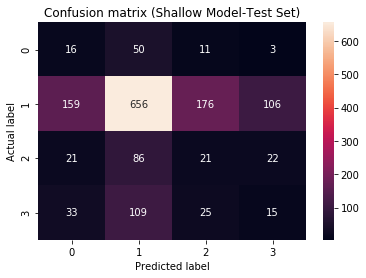

In [28]:
test_preds = np.argmax(S_pred, axis=-1)
test_trues = test_generator.classes
cm = confusion_matrix(test_trues, test_preds)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix (Shallow Model-Test Set)')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [29]:
# Precision, Recall and F1-Score
beer_precision = (cm[0][0])/(cm[0][0]+cm[1][0]+cm[2][0]+cm[3][0])
beer_recall = (cm[0][0])/(cm[0][0]+cm[0][1]+cm[0][2]+cm[0][3])
beer_f1_score = (2*beer_precision*beer_recall)/(beer_precision+beer_recall)
                                           
not_phonebeer_precision = (cm[1][1])/(cm[1][1]+cm[1][0]+cm[1][2]+cm[1][3])
not_phonebeer_recall = (cm[1][1])/(cm[1][1]+cm[0][1]+cm[2][1]+cm[3][1])
not_phonebeer_f1_score = (2*not_phonebeer_precision*not_phonebeer_recall)/(not_phonebeer_precision+not_phonebeer_recall)

otherphones_precision = (cm[2][2])/(cm[2][2]+cm[2][0]+cm[2][1]+cm[2][3])
otherphones_recall = (cm[2][2])/(cm[2][2]+cm[0][2]+cm[1][2]+cm[3][2])
otherphones_f1_score = (2*otherphones_precision*otherphones_recall)/(otherphones_precision+otherphones_recall)

samsung_precision = (cm[3][3])/(cm[3][3]+cm[3][0]+cm[3][1]+cm[3][2])
samsung_recall = (cm[3][3])/(cm[3][3]+cm[0][3]+cm[1][3]+cm[2][3])
samsung_f1_score = (2*samsung_precision*samsung_recall)/(samsung_precision+samsung_recall)

print("Beer Precision = ", beer_precision)
print("Beer Recall = ", beer_recall)
print("Beer F1-Score = ", beer_f1_score)

print("Negative Precision = ", not_phonebeer_precision)
print("Negative Recall = ", not_phonebeer_recall)
print("Negative F1-Score = ", not_phonebeer_f1_score)

print("Other Phones Precision = ", otherphones_precision)
print("Other Phones Recall = ", otherphones_recall)
print("Other Phones F1-Score = ", otherphones_f1_score)

print("Samsung Precision = ", samsung_precision)
print("Samsung Phones Recall = ", samsung_recall)
print("Samsung Phones F1-Score = ", samsung_f1_score)

Beer Precision =  0.06986899563318777
Beer Recall =  0.2
Beer F1-Score =  0.10355987055016182
Negative Precision =  0.5979945305378305
Negative Recall =  0.7280799112097669
Negative F1-Score =  0.6566566566566566
Other Phones Precision =  0.14
Other Phones Recall =  0.09012875536480687
Other Phones F1-Score =  0.10966057441253264
Samsung Precision =  0.08241758241758242
Samsung Phones Recall =  0.10273972602739725
Samsung Phones F1-Score =  0.09146341463414634


### Deep CNN 
Evolution of the previous "Shallow Model", inspired by VGG16 architure (one of my benchmarks)


In [30]:
def deep_NN():
# Initialise a model
    model = Sequential()

# 1st conv block
    model.add(Conv2D(32, KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', use_bias=True, strides=1,
                    padding = 'same'))
# Batch Normalization
    model.add(BatchNormalization())
# 1st pool layer
    model.add(MaxPooling2D(pool_size=POOL_SIZE, strides=2))
    
# 2nd conv block
    model.add(Conv2D(64, KERNEL_SIZE, activation='relu', strides=1, use_bias=True, padding = 'same'))
    model.add(Conv2D(128, KERNEL_SIZE, activation='relu', strides=1, use_bias=True, padding = 'same'))
# Batch Normalization
    model.add(BatchNormalization())    
# 2nd pool layer
    model.add(MaxPooling2D(pool_size=POOL_SIZE, strides=2))
    
# 3rd conv block
    model.add(Conv2D(256, KERNEL_SIZE, activation='relu', strides=1, use_bias=True, padding = 'same'))
# Batch Normalization
    model.add(BatchNormalization())    
# 3rd pool layer
    model.add(MaxPooling2D(pool_size=POOL_SIZE, strides=2))
    
# 4th conv block
    model.add(Conv2D(512, KERNEL_SIZE, activation='relu', strides=1, use_bias=True, padding = 'same'))
    model.add(Conv2D(512, KERNEL_SIZE, activation='relu', strides=1, use_bias=True, padding = 'same'))
# Batch Normalization
    model.add(BatchNormalization())
# 4th pool layer
    model.add(MaxPooling2D(pool_size=POOL_SIZE, strides=2))    
    
# Flattening
    model.add(Flatten())

# FC layers
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=4, activation='softmax'))
    
    return model

In [31]:
deep_model = deep_NN()

In [32]:
deep_model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [33]:
deep_batch_size = 64
deep_epochs = 350

In [34]:
deep_model.fit_generator(train_generator, steps_per_epoch=1024//deep_batch_size, epochs=deep_epochs,
                         validation_data=dev_generator, validation_steps=512//deep_batch_size, 
                         class_weight=class_weights)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/350
16/16 [==============================] - 15s 480ms/step - loss: 24.7616 - accuracy: 0.2853 - val_loss: 1.4108 - val_accuracy: 0.1250
Epoch 2/350
16/16 [==============================] - 8s 461ms/step - loss: 7.1665 - accuracy: 0.1952 - val_loss: 1.5392 - val_accuracy: 0.0898
Epoch 3/350
16/16 [==============================] - 8s 467ms/step - loss: 6.5336 - accuracy: 0.1960 - val_loss: 1.8188 - val_accuracy: 0.0938
Epoch 4/350
16/16 [==============================] - 7s 455ms/step - loss: 5.9901 - accuracy: 0.1543 - val_loss: 1.3973 - val_accuracy: 0.0977
Epoch 5/350
16/16 [==============================] - 8s 472ms/step - loss: 6.4140 - accuracy: 0.1116 - val_loss: 2.6890 - val_accuracy: 0.0781
Epoch 6/350
16/16 [==============================] - 10s 626ms/step - loss: 5.4718 - accuracy: 0.0810 - val_loss: 2.6379 - val_accuracy: 0.0898
Epoch 7/350
16/16 [==============================] - 8s 486ms/step - loss: 6.1365 - accuracy: 0.0998 - val_loss: 1.6047 - val_accuracy: 0.1

In [30]:
deep_model.save_weights('deep_NN_b64_e350.h5')

In [29]:
deep_model.load_weights('deep_NN_b64_e350.h5')

In [35]:
deep_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 192, 240, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 240, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 96, 120, 32)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 96, 120, 64)       18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 96, 120, 128)      73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 120, 128)      512       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 60, 128)      

### Deep model, 350 epochs with BatchNorm, Adam learning rate of 0.0001

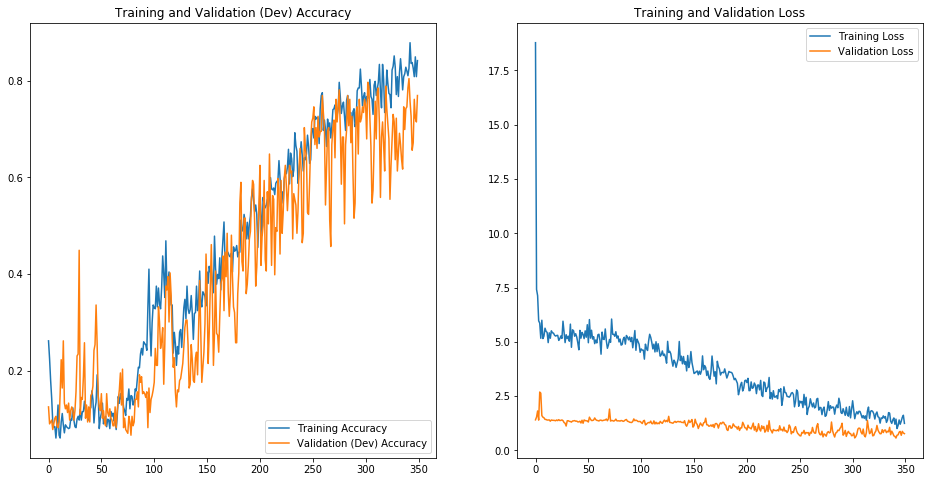

In [36]:
deep_acc = deep_model.history.history['accuracy']
deep_val_acc = deep_model.history.history['val_accuracy']

deep_loss = deep_model.history.history['loss']
deep_val_loss = deep_model.history.history['val_loss']

deep_epoch_range = range(deep_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(deep_epoch_range, deep_acc, label='Training Accuracy')
plt.plot(deep_epoch_range, deep_val_acc, label='Validation (Dev) Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation (Dev) Accuracy')

plt.subplot(1, 2, 2)
plt.plot(deep_epoch_range, deep_loss, label='Training Loss')
plt.plot(deep_epoch_range, deep_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
steps = 53
D_pred = deep_model.predict_generator(dev_generator, steps=steps)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Text(0.5, 15.0, 'Predicted label')

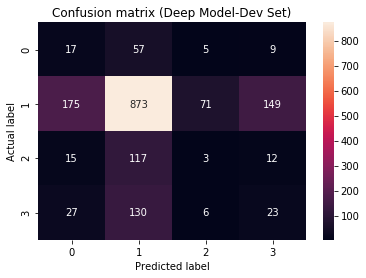

In [40]:
test_preds = np.argmax(D_pred, axis=-1)
test_trues = dev_generator.classes
cm = confusion_matrix(test_trues, test_preds)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix (Deep Model-Dev Set)')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [41]:
# Precision, Recall and F1-Score
beer_precision = (cm[0][0])/(cm[0][0]+cm[1][0]+cm[2][0]+cm[3][0])
beer_recall = (cm[0][0])/(cm[0][0]+cm[0][1]+cm[0][2]+cm[0][3])
beer_f1_score = (2*beer_precision*beer_recall)/(beer_precision+beer_recall)
                                           
not_phonebeer_precision = (cm[1][1])/(cm[1][1]+cm[1][0]+cm[1][2]+cm[1][3])
not_phonebeer_recall = (cm[1][1])/(cm[1][1]+cm[0][1]+cm[2][1]+cm[3][1])
not_phonebeer_f1_score = (2*not_phonebeer_precision*not_phonebeer_recall)/(not_phonebeer_precision+not_phonebeer_recall)

otherphones_precision = (cm[2][2])/(cm[2][2]+cm[2][0]+cm[2][1]+cm[2][3])
otherphones_recall = (cm[2][2])/(cm[2][2]+cm[0][2]+cm[1][2]+cm[3][2])
otherphones_f1_score = (2*otherphones_precision*otherphones_recall)/(otherphones_precision+otherphones_recall)

samsung_precision = (cm[3][3])/(cm[3][3]+cm[3][0]+cm[3][1]+cm[3][2])
samsung_recall = (cm[3][3])/(cm[3][3]+cm[0][3]+cm[1][3]+cm[2][3])
samsung_f1_score = (2*samsung_precision*samsung_recall)/(samsung_precision+samsung_recall)

print("Beer Precision = ", beer_precision)
print("Beer Recall = ", beer_recall)
print("Beer F1-Score = ", beer_f1_score)

print("Negative Precision = ", not_phonebeer_precision)
print("Negative Recall = ", not_phonebeer_recall)
print("Negative F1-Score = ", not_phonebeer_f1_score)

print("Other Phones Precision = ", otherphones_precision)
print("Other Phones Recall = ", otherphones_recall)
print("Other Phones F1-Score = ", otherphones_f1_score)

print("Samsung Precision = ", samsung_precision)
print("Samsung Phones Recall = ", samsung_recall)
print("Samsung Phones F1-Score = ", samsung_f1_score)

Beer Precision =  0.07264957264957266
Beer Recall =  0.19318181818181818
Beer F1-Score =  0.10559006211180125
Negative Precision =  0.6884858044164038
Negative Recall =  0.7417162276975361
Negative F1-Score =  0.7141104294478527
Other Phones Precision =  0.02040816326530612
Other Phones Recall =  0.03529411764705882
Other Phones F1-Score =  0.02586206896551724
Samsung Precision =  0.12365591397849462
Samsung Phones Recall =  0.11917098445595854
Samsung Phones F1-Score =  0.12137203166226913


In [43]:
steps = 48
D_pred = deep_model.predict_generator(test_generator, steps=steps)

Text(0.5, 15.0, 'Predicted label')

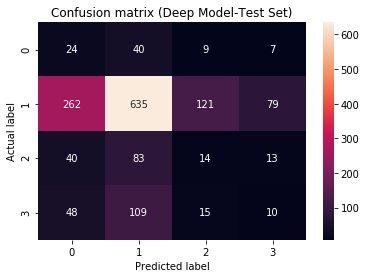

In [44]:
test_preds = np.argmax(D_pred, axis=-1)
test_trues = test_generator.classes
cm = confusion_matrix(test_trues, test_preds)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix (Deep Model-Test Set)')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [45]:
# Precision, Recall and F1-Score
beer_precision = (cm[0][0])/(cm[0][0]+cm[1][0]+cm[2][0]+cm[3][0])
beer_recall = (cm[0][0])/(cm[0][0]+cm[0][1]+cm[0][2]+cm[0][3])
beer_f1_score = (2*beer_precision*beer_recall)/(beer_precision+beer_recall)
                                           
not_phonebeer_precision = (cm[1][1])/(cm[1][1]+cm[1][0]+cm[1][2]+cm[1][3])
not_phonebeer_recall = (cm[1][1])/(cm[1][1]+cm[0][1]+cm[2][1]+cm[3][1])
not_phonebeer_f1_score = (2*not_phonebeer_precision*not_phonebeer_recall)/(not_phonebeer_precision+not_phonebeer_recall)

otherphones_precision = (cm[2][2])/(cm[2][2]+cm[2][0]+cm[2][1]+cm[2][3])
otherphones_recall = (cm[2][2])/(cm[2][2]+cm[0][2]+cm[1][2]+cm[3][2])
otherphones_f1_score = (2*otherphones_precision*otherphones_recall)/(otherphones_precision+otherphones_recall)

samsung_precision = (cm[3][3])/(cm[3][3]+cm[3][0]+cm[3][1]+cm[3][2])
samsung_recall = (cm[3][3])/(cm[3][3]+cm[0][3]+cm[1][3]+cm[2][3])
samsung_f1_score = (2*samsung_precision*samsung_recall)/(samsung_precision+samsung_recall)

print("Beer Precision = ", beer_precision)
print("Beer Recall = ", beer_recall)
print("Beer F1-Score = ", beer_f1_score)

print("Negative Precision = ", not_phonebeer_precision)
print("Negative Recall = ", not_phonebeer_recall)
print("Negative F1-Score = ", not_phonebeer_f1_score)

print("Other Phones Precision = ", otherphones_precision)
print("Other Phones Recall = ", otherphones_recall)
print("Other Phones F1-Score = ", otherphones_f1_score)

print("Samsung Precision = ", samsung_precision)
print("Samsung Phones Recall = ", samsung_recall)
print("Samsung Phones F1-Score = ", samsung_f1_score)

Beer Precision =  0.06417112299465241
Beer Recall =  0.3
Beer F1-Score =  0.10572687224669605
Negative Precision =  0.5788514129443938
Negative Recall =  0.7324106113033448
Negative F1-Score =  0.6466395112016293
Other Phones Precision =  0.09333333333333334
Other Phones Recall =  0.0880503144654088
Other Phones F1-Score =  0.09061488673139159
Samsung Precision =  0.054945054945054944
Samsung Phones Recall =  0.09174311926605505
Samsung Phones F1-Score =  0.06872852233676975


### Visualizing filters

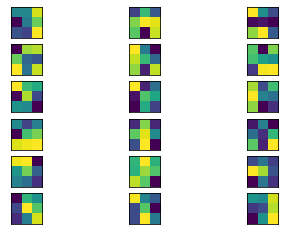

In [46]:
# retrieve weights from the second hidden layer and normalize filter values to 0-1 so we can visualize them
filters, biases = deep_model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plotting first few filters
n_filters, ix = 6, 1
for i in range(n_filters): # get the filter
    f = filters[:, :, :, i]
# plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j])
        ix += 1
# show the figure
pyplot.show()

### Feature Map

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  [(None, 192, 240, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 192, 240, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 240, 32)      128       
Total params: 1,024
Trainable params: 960
Non-trainable params: 64
_________________________________________________________________


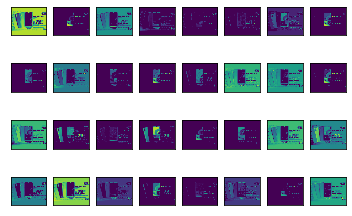

In [47]:
# redefine model to output right after the first hidden layer
deep_model = Model(inputs=deep_model.inputs, outputs=deep_model.layers[1].output)
deep_model.summary()
# load the image with the required shape
img = load_img('data/frames/test/samsung/1296184800010.png', target_size=(192, 240))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = deep_model.predict(img)
# plot 32 maps in an 4x4 squares
w = 8
h = 4
ix = 1
for _ in range(w):
    for _ in range(h):
        # specify subplot and turn of axis
        ax = pyplot.subplot(h, w, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1])
        ix += 1
# show the figure
pyplot.show()

### Going deeper to final architecture

In [18]:
def deeper_NN():
# Initialise a model
    model = Sequential()

# 1st conv layer
    model.add(Conv2D(64, (5, 5), input_shape=INPUT_SHAPE, activation='relu', use_bias=True, strides=1,
                    padding = 'same'))
# Batch Normalization
    model.add(BatchNormalization())
# 1st pool layer
    model.add(MaxPooling2D(pool_size=POOL_SIZE, strides=2))
    
# 2nd conv layer
    model.add(Conv2D(64, KERNEL_SIZE, activation='relu', strides=1, use_bias=True, padding = 'same'))
    model.add(Conv2D(128, KERNEL_SIZE, activation='relu', strides=1, use_bias=True, padding = 'same'))
# Batch Normalization
    model.add(BatchNormalization())    
# 2nd pool layer
    model.add(MaxPooling2D(pool_size=POOL_SIZE, strides=2))
    
# 3rd conv layer
    model.add(Conv2D(256, KERNEL_SIZE, activation='relu', strides=1, use_bias=True, padding = 'same'))
    model.add(Conv2D(256, KERNEL_SIZE, activation='relu', strides=1, use_bias=True, padding = 'same'))
# Batch Normalization
    model.add(BatchNormalization())    
# 3rd pool layer
    model.add(MaxPooling2D(pool_size=POOL_SIZE, strides=2))
    
# 4th conv layer
    model.add(Conv2D(512, KERNEL_SIZE, activation='relu', strides=1, use_bias=True, padding = 'same'))
    model.add(Conv2D(512, KERNEL_SIZE, activation='relu', strides=1, use_bias=True, padding = 'same'))
    model.add(Conv2D(512, KERNEL_SIZE, activation='relu', strides=1, use_bias=True, padding = 'same'))
# Batch Normalization
    model.add(BatchNormalization())
# 4th pool layer
    model.add(MaxPooling2D(pool_size=POOL_SIZE, strides=2))    
    
# Flattening
    model.add(Flatten())

# FC layers
    model.add(Dense(units=1024, activation='relu'))
    model.add(Dense(units=1024, activation='relu'))
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=4, activation='softmax'))
    
    return model

In [19]:
deeper_model = deeper_NN()

In [20]:
deeper_model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [21]:
deeper_batch_size = 64
deeper_epochs = 350

In [22]:
deeper_model.fit_generator(train_generator, steps_per_epoch=1024//deeper_batch_size, epochs=deeper_epochs,
                         validation_data=dev_generator, validation_steps=512//deeper_batch_size, 
                         class_weight=class_weights)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/350
16/16 [==============================] - 34s 662ms/step - loss: 21.1729 - accuracy: 0.3063 - val_loss: 0.8560 - val_accuracy: 0.7539
Epoch 2/350
16/16 [==============================] - 11s 665ms/step - loss: 12.0045 - accuracy: 0.2220 - val_loss: 1.1513 - val_accuracy: 0.7539
Epoch 3/350
16/16 [==============================] - 10s 627ms/step - loss: 6.4295 - accuracy: 0.2667 - val_loss: 4.3275 - val_accuracy: 0.1250
Epoch 4/350
16/16 [==============================] - 10s 634ms/step - loss: 6.3227 - accuracy: 0.3985 - val_loss: 2.9225 - val_accuracy: 0.0938
Epoch 5/350
16/16 [==============================] - 14s 854ms/step - loss: 6.0984 - accuracy: 0.4102 - val_loss: 2.3133 - val_accuracy: 0.1133
Epoch 6/350
16/16 [==============================] - 11s 643ms/step - loss: 5.5156 - accuracy: 0.3156 - val_loss: 1.4832 - val_accuracy: 0.7578
Epoch 7/350
16/16 [==============================] - 10s 638ms/step - loss: 6.2991 - accuracy: 0.3641 - val_loss: 1.1576 - val_accurac

In [44]:
deeper_model.save_weights('deeper_NN_b64_e400.h5')

In [18]:
deeper_model.load_weights('deeper_NN_b64_e350.h5')

In [23]:
deeper_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 192, 240, 64)      4864      
_________________________________________________________________
batch_normalization_4 (Batch (None, 192, 240, 64)      256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 96, 120, 64)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 96, 120, 64)       36928     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 96, 120, 128)      73856     
_________________________________________________________________
batch_normalization_5 (Batch (None, 96, 120, 128)      512       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 60, 128)      

### Deeper model, 350 epochs with BatchNorm, Adam learning rate of 0.0001

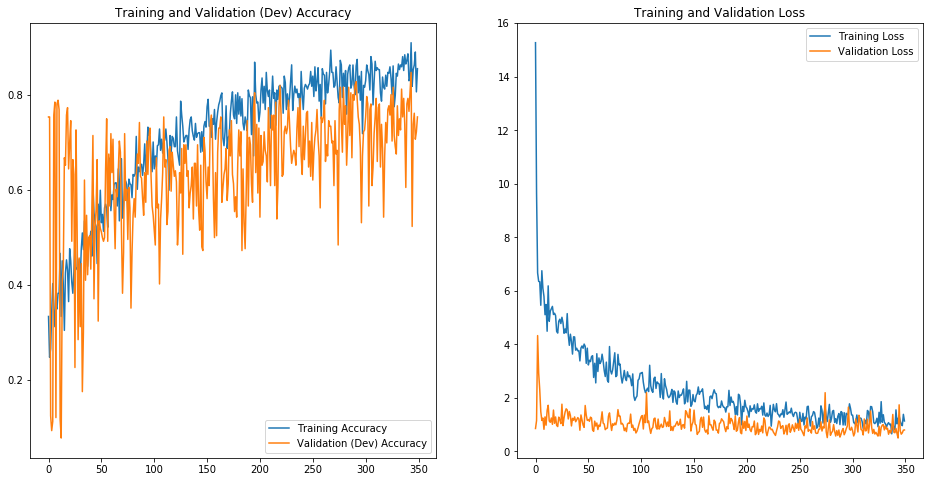

In [24]:
deeper_acc = deeper_model.history.history['accuracy']
deeper_val_acc = deeper_model.history.history['val_accuracy']

deeper_loss = deeper_model.history.history['loss']
deeper_val_loss = deeper_model.history.history['val_loss']

deeper_epoch_range = range(deeper_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(deeper_epoch_range, deeper_acc, label='Training Accuracy')
plt.plot(deeper_epoch_range, deeper_val_acc, label='Validation (Dev) Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation (Dev) Accuracy')

plt.subplot(1, 2, 2)
plt.plot(deeper_epoch_range, deeper_loss, label='Training Loss')
plt.plot(deeper_epoch_range, deeper_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
deeper_scores = deeper_model.evaluate(dev_generator)
print("Accuracy = ", deeper_scores[1])

53/53 [==============================] - 14s 254ms/step - loss: 0.7293 - accuracy: 0.7792
Accuracy =  0.7791592478752136


In [26]:
deeper_scores = deeper_model.evaluate(test_generator)
print("Accuracy = ", deeper_scores[1])

48/48 [==============================] - 9s 194ms/step - loss: 0.4976 - accuracy: 0.8217
Accuracy =  0.8217362761497498


In [27]:
steps = 53
DD_pred = deeper_model.predict_generator(dev_generator, steps=steps)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Text(0.5, 15.0, 'Predicted label')

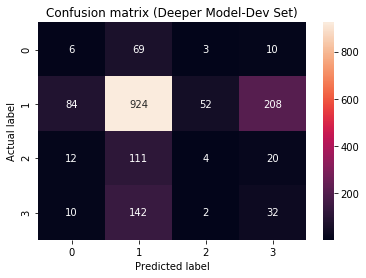

In [28]:
test_preds = np.argmax(DD_pred, axis=-1)
test_trues = dev_generator.classes
cm = confusion_matrix(test_trues, test_preds)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix (Deeper Model-Dev Set)')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [29]:
# Precision, Recall and F1-Score
beer_precision = (cm[0][0])/(cm[0][0]+cm[1][0]+cm[2][0]+cm[3][0])
beer_recall = (cm[0][0])/(cm[0][0]+cm[0][1]+cm[0][2]+cm[0][3])
beer_f1_score = (2*beer_precision*beer_recall)/(beer_precision+beer_recall)
                                           
not_phonebeer_precision = (cm[1][1])/(cm[1][1]+cm[1][0]+cm[1][2]+cm[1][3])
not_phonebeer_recall = (cm[1][1])/(cm[1][1]+cm[0][1]+cm[2][1]+cm[3][1])
not_phonebeer_f1_score = (2*not_phonebeer_precision*not_phonebeer_recall)/(not_phonebeer_precision+not_phonebeer_recall)

otherphones_precision = (cm[2][2])/(cm[2][2]+cm[2][0]+cm[2][1]+cm[2][3])
otherphones_recall = (cm[2][2])/(cm[2][2]+cm[0][2]+cm[1][2]+cm[3][2])
otherphones_f1_score = (2*otherphones_precision*otherphones_recall)/(otherphones_precision+otherphones_recall)

samsung_precision = (cm[3][3])/(cm[3][3]+cm[3][0]+cm[3][1]+cm[3][2])
samsung_recall = (cm[3][3])/(cm[3][3]+cm[0][3]+cm[1][3]+cm[2][3])
samsung_f1_score = (2*samsung_precision*samsung_recall)/(samsung_precision+samsung_recall)

print("Beer Precision = ", beer_precision)
print("Beer Recall = ", beer_recall)
print("Beer F1-Score = ", beer_f1_score)

print("Negative Precision = ", not_phonebeer_precision)
print("Negative Recall = ", not_phonebeer_recall)
print("Negative F1-Score = ", not_phonebeer_f1_score)

print("Other Phones Precision = ", otherphones_precision)
print("Other Phones Recall = ", otherphones_recall)
print("Other Phones F1-Score = ", otherphones_f1_score)

print("Samsung Precision = ", samsung_precision)
print("Samsung Phones Recall = ", samsung_recall)
print("Samsung Phones F1-Score = ", samsung_f1_score)

Beer Precision =  0.05357142857142857
Beer Recall =  0.06818181818181818
Beer F1-Score =  0.05999999999999999
Negative Precision =  0.7287066246056783
Negative Recall =  0.7415730337078652
Negative F1-Score =  0.7350835322195705
Other Phones Precision =  0.027210884353741496
Other Phones Recall =  0.06557377049180328
Other Phones F1-Score =  0.03846153846153846
Samsung Precision =  0.17204301075268819
Samsung Phones Recall =  0.11851851851851852
Samsung Phones F1-Score =  0.14035087719298248


In [31]:
steps = 48
DDt_pred = deeper_model.predict_generator(test_generator, steps=steps)

Text(0.5, 15.0, 'Predicted label')

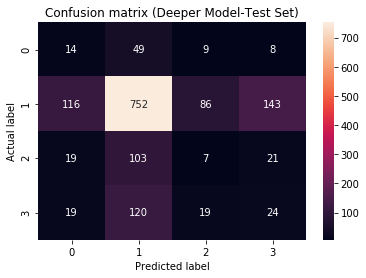

In [32]:
test_preds = np.argmax(DDt_pred, axis=-1)
test_trues = test_generator.classes
cm = confusion_matrix(test_trues, test_preds)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix (Deeper Model-Test Set)')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [33]:
# Precision, Recall and F1-Score
beer_precision = (cm[0][0])/(cm[0][0]+cm[1][0]+cm[2][0]+cm[3][0])
beer_recall = (cm[0][0])/(cm[0][0]+cm[0][1]+cm[0][2]+cm[0][3])
beer_f1_score = (2*beer_precision*beer_recall)/(beer_precision+beer_recall)
                                           
not_phonebeer_precision = (cm[1][1])/(cm[1][1]+cm[1][0]+cm[1][2]+cm[1][3])
not_phonebeer_recall = (cm[1][1])/(cm[1][1]+cm[0][1]+cm[2][1]+cm[3][1])
not_phonebeer_f1_score = (2*not_phonebeer_precision*not_phonebeer_recall)/(not_phonebeer_precision+not_phonebeer_recall)

otherphones_precision = (cm[2][2])/(cm[2][2]+cm[2][0]+cm[2][1]+cm[2][3])
otherphones_recall = (cm[2][2])/(cm[2][2]+cm[0][2]+cm[1][2]+cm[3][2])
otherphones_f1_score = (2*otherphones_precision*otherphones_recall)/(otherphones_precision+otherphones_recall)

samsung_precision = (cm[3][3])/(cm[3][3]+cm[3][0]+cm[3][1]+cm[3][2])
samsung_recall = (cm[3][3])/(cm[3][3]+cm[0][3]+cm[1][3]+cm[2][3])
samsung_f1_score = (2*samsung_precision*samsung_recall)/(samsung_precision+samsung_recall)

print("Beer Precision = ", beer_precision)
print("Beer Recall = ", beer_recall)
print("Beer F1-Score = ", beer_f1_score)

print("Negative Precision = ", not_phonebeer_precision)
print("Negative Recall = ", not_phonebeer_recall)
print("Negative F1-Score = ", not_phonebeer_f1_score)

print("Other Phones Precision = ", otherphones_precision)
print("Other Phones Recall = ", otherphones_recall)
print("Other Phones F1-Score = ", otherphones_f1_score)

print("Samsung Precision = ", samsung_precision)
print("Samsung Phones Recall = ", samsung_recall)
print("Samsung Phones F1-Score = ", samsung_f1_score)

Beer Precision =  0.08333333333333333
Beer Recall =  0.175
Beer F1-Score =  0.11290322580645161
Negative Precision =  0.6855059252506837
Negative Recall =  0.734375
Negative F1-Score =  0.7090994813767092
Other Phones Precision =  0.04666666666666667
Other Phones Recall =  0.05785123966942149
Other Phones F1-Score =  0.05166051660516606
Samsung Precision =  0.13186813186813187
Samsung Phones Recall =  0.12244897959183673
Samsung Phones F1-Score =  0.12698412698412698


### Visualizing filters

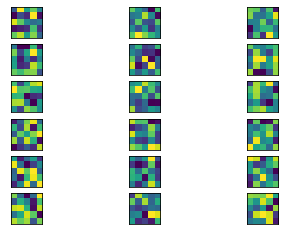

In [26]:
# retrieve weights from the second hidden layer and normalize filter values to 0-1 so we can visualize them
filters, biases = deeper_model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plotting first few filters
n_filters, ix = 6, 1
for i in range(n_filters): # get the filter
    f = filters[:, :, :, i]
# plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j])
        ix += 1
# show the figure
pyplot.show()

### Feature Map

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  [(None, 192, 240, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 192, 240, 64)      1792      
_________________________________________________________________
batch_normalization_2 (Batch (None, 192, 240, 64)      256       
Total params: 2,048
Trainable params: 1,920
Non-trainable params: 128
_________________________________________________________________


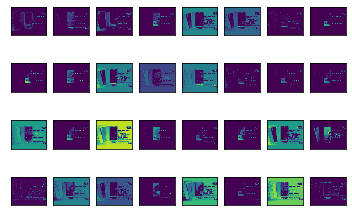

In [44]:
# redefine model to output right after the first hidden layer
deeper_model = Model(inputs=deeper_model.inputs, outputs=deeper_model.layers[1].output)
deeper_model.summary()
# load the image with the required shape
img = load_img('data/frames/test/samsung/1296184800009.png', target_size=(192, 240))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = deeper_model.predict(img)
# plot 32 maps in an 4x4 squares
w = 8
h = 4
ix = 1
for _ in range(w):
    for _ in range(h):
        # specify subplot and turn of axis
        ax = pyplot.subplot(h, w, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1])
        ix += 1
# show the figure
pyplot.show()

### As benchmarks, I trained the model on adapted architectures to comparison
- VGG16
- Andrej Karpathy's work to classify single frames in YouTube video classification

In [45]:
vgg16 = VGG16(include_top=False, input_shape=INPUT_SHAPE)

In [46]:
last = vgg16.output

X = Flatten()(last)
X = Dense(64, activation='relu')(X)

out_layer = Dense(4, activation='softmax')(X)

vgg16 = Model(vgg16.input, out_layer)

In [47]:
vgg16.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 192, 240, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 120, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 120, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 120, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 60, 128)       0   

In [48]:
vgg16.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [49]:
vgg16_batch_size = 64
vgg16_epochs = 350

In [50]:
vgg16.fit_generator(train_generator, steps_per_epoch=1024//vgg16_batch_size, epochs=vgg16_epochs,
                         validation_data=dev_generator, validation_steps=512//vgg16_batch_size, 
                         class_weight=class_weights)

Epoch 1/350
16/16 [==============================] - 16s 929ms/step - loss: 8.9165 - accuracy: 0.2012 - val_loss: 1.3661 - val_accuracy: 0.0781
Epoch 2/350
16/16 [==============================] - 15s 900ms/step - loss: 4.6862 - accuracy: 0.2234 - val_loss: 1.4711 - val_accuracy: 0.1016
Epoch 3/350
16/16 [==============================] - 15s 900ms/step - loss: 5.6755 - accuracy: 0.1401 - val_loss: 1.3681 - val_accuracy: 0.0664
Epoch 4/350
16/16 [==============================] - 15s 903ms/step - loss: 5.2279 - accuracy: 0.3339 - val_loss: 1.4327 - val_accuracy: 0.0703
Epoch 5/350
16/16 [==============================] - 15s 904ms/step - loss: 5.4918 - accuracy: 0.0581 - val_loss: 1.4139 - val_accuracy: 0.0625
Epoch 6/350
16/16 [==============================] - 15s 908ms/step - loss: 5.1716 - accuracy: 0.0939 - val_loss: 1.3756 - val_accuracy: 0.3125
Epoch 7/350
16/16 [==============================] - 15s 908ms/step - loss: 4.8371 - accuracy: 0.4163 - val_loss: 1.3877 - val_accuracy:

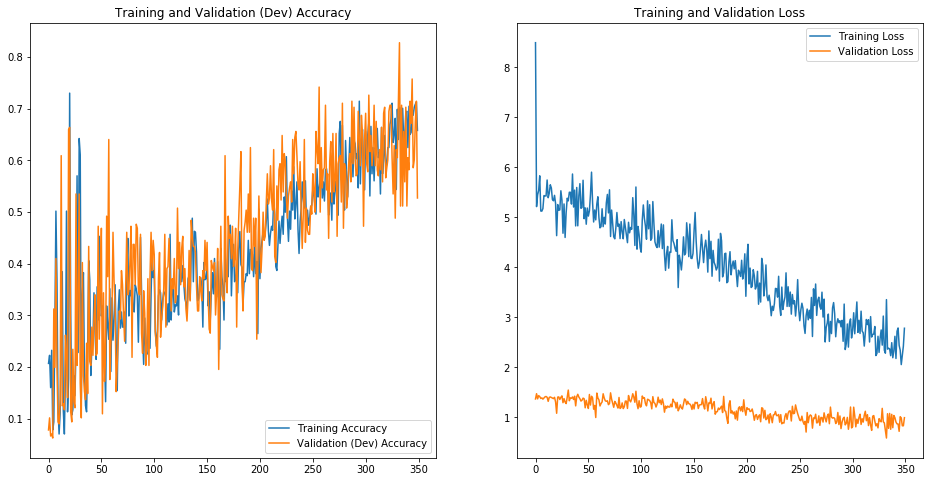

In [51]:
vgg16_acc = vgg16.history.history['accuracy']
vgg16_val_acc = vgg16.history.history['val_accuracy']

vgg16_loss = vgg16.history.history['loss']
vgg16_val_loss = vgg16.history.history['val_loss']

vgg16_epoch_range = range(vgg16_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(vgg16_epoch_range, vgg16_acc, label='Training Accuracy')
plt.plot(vgg16_epoch_range, vgg16_val_acc, label='Validation (Dev) Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation (Dev) Accuracy')

plt.subplot(1, 2, 2)
plt.plot(vgg16_epoch_range, vgg16_loss, label='Training Loss')
plt.plot(vgg16_epoch_range, vgg16_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [60]:
vgg16.save_weights('vgg16_NN_b64_e100.h5')

In [52]:
vgg16_scores = vgg16.evaluate(dev_generator)
print("Accuracy = ", vgg16_scores[1])

53/53 [==============================] - 16s 304ms/step - loss: 0.9939 - accuracy: 0.5293
Accuracy =  0.5293073058128357


In [53]:
steps = 53
VGG_pred = vgg16.predict_generator(dev_generator, steps=steps)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Text(0.5, 15.0, 'Predicted label')

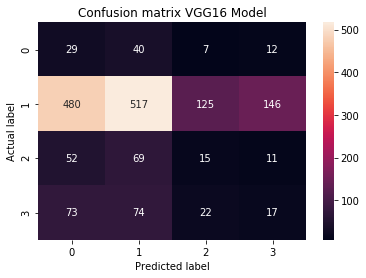

In [54]:
test_preds = np.argmax(VGG_pred, axis=-1)
test_trues = dev_generator.classes
cm = confusion_matrix(test_trues, test_preds)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix VGG16 Model')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [55]:
# Precision, Recall and F1-Score
beer_precision = (cm[0][0])/(cm[0][0]+cm[1][0]+cm[2][0]+cm[3][0])
beer_recall = (cm[0][0])/(cm[0][0]+cm[0][1]+cm[0][2]+cm[0][3])
beer_f1_score = (2*beer_precision*beer_recall)/(beer_precision+beer_recall)
                                           
not_phonebeer_precision = (cm[1][1])/(cm[1][1]+cm[1][0]+cm[1][2]+cm[1][3])
not_phonebeer_recall = (cm[1][1])/(cm[1][1]+cm[0][1]+cm[2][1]+cm[3][1])
not_phonebeer_f1_score = (2*not_phonebeer_precision*not_phonebeer_recall)/(not_phonebeer_precision+not_phonebeer_recall)

otherphones_precision = (cm[2][2])/(cm[2][2]+cm[2][0]+cm[2][1]+cm[2][3])
otherphones_recall = (cm[2][2])/(cm[2][2]+cm[0][2]+cm[1][2]+cm[3][2])
otherphones_f1_score = (2*otherphones_precision*otherphones_recall)/(otherphones_precision+otherphones_recall)

samsung_precision = (cm[3][3])/(cm[3][3]+cm[3][0]+cm[3][1]+cm[3][2])
samsung_recall = (cm[3][3])/(cm[3][3]+cm[0][3]+cm[1][3]+cm[2][3])
samsung_f1_score = (2*samsung_precision*samsung_recall)/(samsung_precision+samsung_recall)

print("Beer Precision = ", beer_precision)
print("Beer Recall = ", beer_recall)
print("Beer F1-Score = ", beer_f1_score)

print("Negative Precision = ", not_phonebeer_precision)
print("Negative Recall = ", not_phonebeer_recall)
print("Negative F1-Score = ", not_phonebeer_f1_score)

print("Other Phones Precision = ", otherphones_precision)
print("Other Phones Recall = ", otherphones_recall)
print("Other Phones F1-Score = ", otherphones_f1_score)

print("Samsung Precision = ", samsung_precision)
print("Samsung Phones Recall = ", samsung_recall)
print("Samsung Phones F1-Score = ", samsung_f1_score)

Beer Precision =  0.04574132492113565
Beer Recall =  0.32954545454545453
Beer F1-Score =  0.08033240997229917
Negative Precision =  0.4077287066246057
Negative Recall =  0.7385714285714285
Negative F1-Score =  0.5254065040650406
Other Phones Precision =  0.10204081632653061
Other Phones Recall =  0.08875739644970414
Other Phones F1-Score =  0.09493670886075949
Samsung Precision =  0.0913978494623656
Samsung Phones Recall =  0.0913978494623656
Samsung Phones F1-Score =  0.09139784946236558


## Karpathy's Single Frame classification used as baseline model in published paper

Single-frame. We use a single-frame baseline architec- ture to understand the contribution of static appearance to the classification accuracy. This network is similar to the ImageNet challenge winning model, but accepts in- puts of size 170 × 170 × 3 pixels instead of the original 224 × 224 × 3. Using shorthand notation, the full architec- ture is C (96, 11, 3)-N -P -C (256, 5, 1)-N -P -C (384, 3, 1)- C (384, 3, 1)-C (256, 3, 1)-P -F C (4096)-F C (4096), where C(d, f, s) indicates a convolutional layer with d filters of spatial size f × f , applied to the input with stride s. F C (n) is a fully connected layer with n nodes. All pooling layers P pool spatially in non-overlapping 2 × 2 regions and all nor- malization layers N are defined as described in Krizhevsky et al. and use the same parameters: k = 2,n = 5,α = 10−4 , β = 0.5. The final layer is connected to a softmax classifier with dense connections.

In [13]:
def karp_NN():
# Initialise a model
    model = Sequential()

# 1st block - I used (5, 5) kernel rathen than (11, 11)
    model.add(Conv2D(96, (5, 5), input_shape=INPUT_SHAPE, activation='relu', use_bias=True, strides=3,
                    padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=POOL_SIZE, strides=2))
    
# 2nd block
    model.add(Conv2D(256, (5, 5), activation='relu', strides=1, use_bias=True, padding = 'same'))
    model.add(BatchNormalization())    
    model.add(MaxPooling2D(pool_size=POOL_SIZE, strides=2))
    
# 3rd block
    model.add(Conv2D(384, KERNEL_SIZE, activation='relu', strides=1, use_bias=True, padding = 'same'))
    model.add(Conv2D(384, KERNEL_SIZE, activation='relu', strides=1, use_bias=True, padding = 'same'))
    model.add(Conv2D(256, KERNEL_SIZE, activation='relu', strides=1, use_bias=True, padding = 'same'))
    model.add(MaxPooling2D(pool_size=POOL_SIZE, strides=2)) 
    
# Flattening
    model.add(Flatten())

# FC layers
    model.add(Dense(units=4096, activation='relu'))
    model.add(Dense(units=4096, activation='relu'))
    model.add(Dense(units=4, activation='softmax'))
    
    return model

In [14]:
karp_model = karp_NN()

In [15]:
karp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 80, 96)        7296      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 80, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 40, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 40, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 40, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 20, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 20, 384)       8

In [16]:
karp_model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [17]:
karp_batch_size = 64
karp_epochs = 350

In [18]:
karp_model.fit_generator(train_generator, steps_per_epoch=1024//karp_batch_size, epochs=karp_epochs,
                         validation_data=dev_generator, validation_steps=512//karp_batch_size, 
                         class_weight=class_weights)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/350
16/16 [==============================] - 26s 589ms/step - loss: 16.6838 - accuracy: 0.3561 - val_loss: 1.3804 - val_accuracy: 0.3828
Epoch 2/350
16/16 [==============================] - 8s 527ms/step - loss: 6.3934 - accuracy: 0.2487 - val_loss: 1.3901 - val_accuracy: 0.0898
Epoch 3/350
16/16 [==============================] - 8s 508ms/step - loss: 4.9995 - accuracy: 0.3746 - val_loss: 1.3670 - val_accuracy: 0.7969
Epoch 4/350
16/16 [==============================] - 8s 490ms/step - loss: 5.6012 - accuracy: 0.5492 - val_loss: 1.3993 - val_accuracy: 0.0898
Epoch 5/350
16/16 [==============================] - 8s 500ms/step - loss: 4.9227 - accuracy: 0.2226 - val_loss: 1.3776 - val_accuracy: 0.2422
Epoch 6/350
16/16 [==============================] - 8s 501ms/step - loss: 5.7895 - accuracy: 0.1804 - val_loss: 1.4194 - val_accuracy: 0.0898
Epoch 7/350
16/16 [==============================] - 8s 522ms/step - loss: 4.2811 - accuracy: 0.2672 - val_loss: 1.3292 - val_accuracy: 0.08

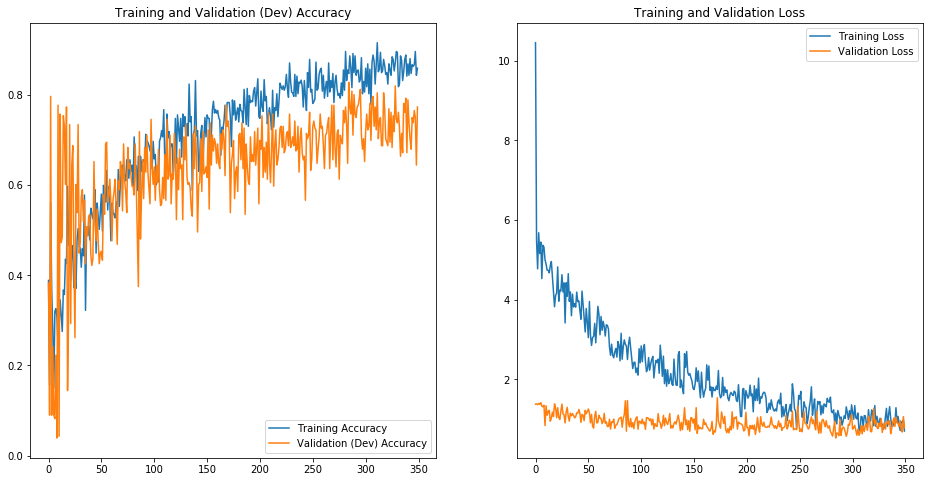

In [19]:
karp_acc = karp_model.history.history['accuracy']
karp_val_acc = karp_model.history.history['val_accuracy']

karp_loss = karp_model.history.history['loss']
karp_val_loss = karp_model.history.history['val_loss']

karp_epoch_range = range(karp_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(karp_epoch_range, karp_acc, label='Training Accuracy')
plt.plot(karp_epoch_range, karp_val_acc, label='Validation (Dev) Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation (Dev) Accuracy')

plt.subplot(1, 2, 2)
plt.plot(karp_epoch_range, karp_loss, label='Training Loss')
plt.plot(karp_epoch_range, karp_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
karp_scores = karp_model.evaluate(dev_generator)
print("Accuracy = ", karp_scores[1])

53/53 [==============================] - 7s 124ms/step - loss: 0.7642 - accuracy: 0.7667
Accuracy =  0.7667258977890015


In [22]:
steps = 53
K_pred = karp_model.predict_generator(dev_generator, steps=steps)

Text(0.5, 15.0, 'Predicted label')

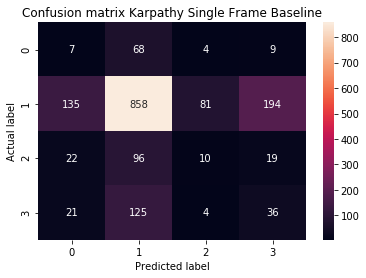

In [24]:
test_preds = np.argmax(K_pred, axis=-1)
test_trues = dev_generator.classes
cm = confusion_matrix(test_trues, test_preds)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix Karpathy Single Frame Baseline')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [25]:
# Precision, Recall and F1-Score
beer_precision = (cm[0][0])/(cm[0][0]+cm[1][0]+cm[2][0]+cm[3][0])
beer_recall = (cm[0][0])/(cm[0][0]+cm[0][1]+cm[0][2]+cm[0][3])
beer_f1_score = (2*beer_precision*beer_recall)/(beer_precision+beer_recall)
                                           
not_phonebeer_precision = (cm[1][1])/(cm[1][1]+cm[1][0]+cm[1][2]+cm[1][3])
not_phonebeer_recall = (cm[1][1])/(cm[1][1]+cm[0][1]+cm[2][1]+cm[3][1])
not_phonebeer_f1_score = (2*not_phonebeer_precision*not_phonebeer_recall)/(not_phonebeer_precision+not_phonebeer_recall)

otherphones_precision = (cm[2][2])/(cm[2][2]+cm[2][0]+cm[2][1]+cm[2][3])
otherphones_recall = (cm[2][2])/(cm[2][2]+cm[0][2]+cm[1][2]+cm[3][2])
otherphones_f1_score = (2*otherphones_precision*otherphones_recall)/(otherphones_precision+otherphones_recall)

samsung_precision = (cm[3][3])/(cm[3][3]+cm[3][0]+cm[3][1]+cm[3][2])
samsung_recall = (cm[3][3])/(cm[3][3]+cm[0][3]+cm[1][3]+cm[2][3])
samsung_f1_score = (2*samsung_precision*samsung_recall)/(samsung_precision+samsung_recall)

print("Beer Precision = ", beer_precision)
print("Beer Recall = ", beer_recall)
print("Beer F1-Score = ", beer_f1_score)

print("Negative Precision = ", not_phonebeer_precision)
print("Negative Recall = ", not_phonebeer_recall)
print("Negative F1-Score = ", not_phonebeer_f1_score)

print("Other Phones Precision = ", otherphones_precision)
print("Other Phones Recall = ", otherphones_recall)
print("Other Phones F1-Score = ", otherphones_f1_score)

print("Samsung Precision = ", samsung_precision)
print("Samsung Phones Recall = ", samsung_recall)
print("Samsung Phones F1-Score = ", samsung_f1_score)

Beer Precision =  0.03783783783783784
Beer Recall =  0.07954545454545454
Beer F1-Score =  0.05128205128205128
Negative Precision =  0.6766561514195584
Negative Recall =  0.7480383609415867
Negative F1-Score =  0.7105590062111802
Other Phones Precision =  0.06802721088435375
Other Phones Recall =  0.10101010101010101
Other Phones F1-Score =  0.0813008130081301
Samsung Precision =  0.1935483870967742
Samsung Phones Recall =  0.13953488372093023
Samsung Phones F1-Score =  0.16216216216216217
